In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import cv2
import timm
from glob import glob
import os
from tqdm import tqdm

# **Configuration** 설정

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/aiConnect_2nd

Mounted at /content/drive
/content/drive/MyDrive/aiConnect_2nd


In [ ]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/0927/train.zip" -d "/content/drive/MyDrive/Colab Notebooks/0927"
# !unzip "/content/drive/MyDrive/Colab Notebooks/0927/test.zip" -d "/content/drive/MyDrive/Colab Notebooks/0927"


In [7]:
# 데이터셋 경로 설정
data_dir = '/content/drive/MyDrive/aiConnect_2nd/data'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [4]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

# **HyperParameters** 하이퍼파라미터

In [5]:
cfg = dotdict(device='cuda',  #'cuda' #cpu
              batch_size=8,
              epochs=13,
              lr=1e-4
              )

# Simple **EDA**: Class Imbalance Problem

In [8]:
# 데이터 수량 체크
train_defect_images = glob(train_dir + '/defect_images/*.png')
train_normal_images = glob(train_dir + '/normal_images/*.png')

print(f'total number of train dataset : {len(train_defect_images) + len(train_normal_images)}')
print(f'defect : {len(train_defect_images)}')
print(f'normal : {len(train_normal_images)}')

total number of train dataset : 6820
defect : 30
normal : 6790


Text(0.5, 1.0, 'dist. of train dataset')

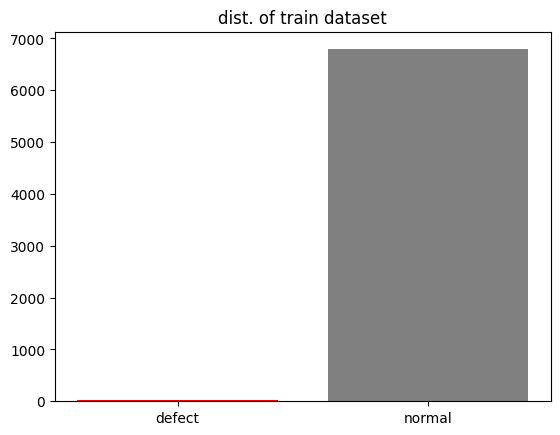

In [9]:
# 클래스 분포 체크
plt.bar(['defect', 'normal'], [len(train_defect_images), len(train_normal_images)], color=['red', 'gray'])
plt.title('dist. of train dataset')

# **Data Augmentation** 데이터증강

In [10]:
from PIL import Image, ImageOps

augmented_images = []
angles = np.arange(0, 360, 10)  # 회전할 각도

for image_path in train_defect_images:  # 처음 30개의 이미지만 사용
    img = Image.open(image_path)

    for flip_func in [None, ImageOps.flip, ImageOps.mirror]:   # 상하 / 좌우 반전 함수 리스트
        flipped_img = img if flip_func is None else flip_func(img)   # 반전

        for angle in angles:
            rotated_img = flipped_img.rotate(angle)
            augmented_images.append(rotated_img)
            # 필요하다면 img_rotated를 디스크에 저장할 수도 있습니다.

augmented_defect_count = len(augmented_images)
print(f"Total augmented images: {augmented_defect_count}")

Total augmented images: 3240


## Augmentation Check

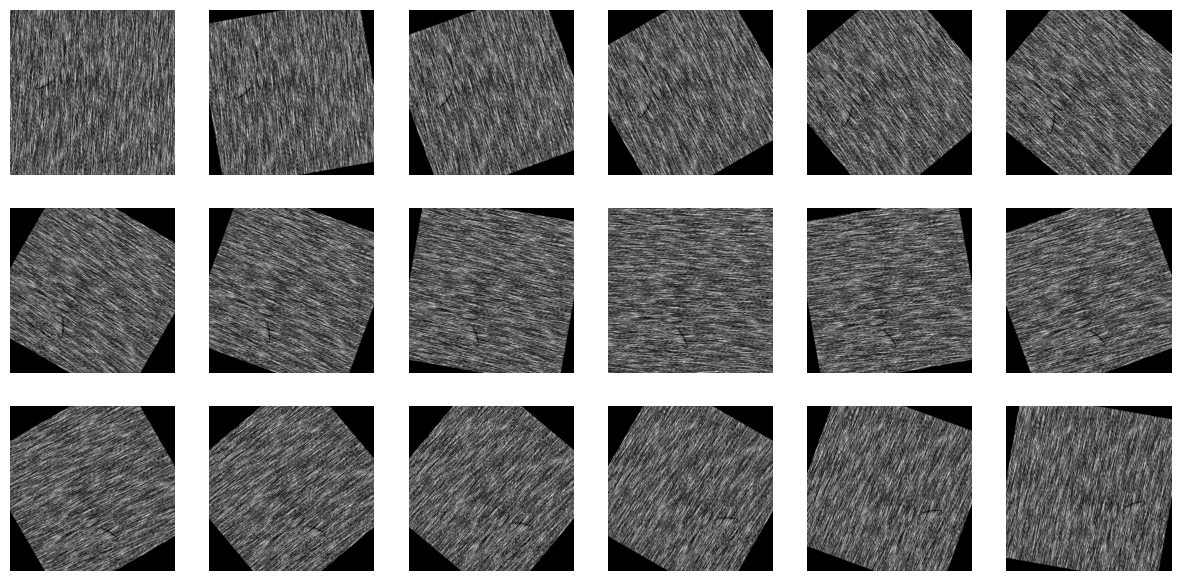

In [11]:
# 상위 10개의 증강 이미지만 시각적으로 확인
plt.figure(figsize=(15, 15))
for i, img in enumerate(augmented_images[:18]):
    plt.subplot(6, 6, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # x, y 축 레이블을 표시하지 않음
plt.show()


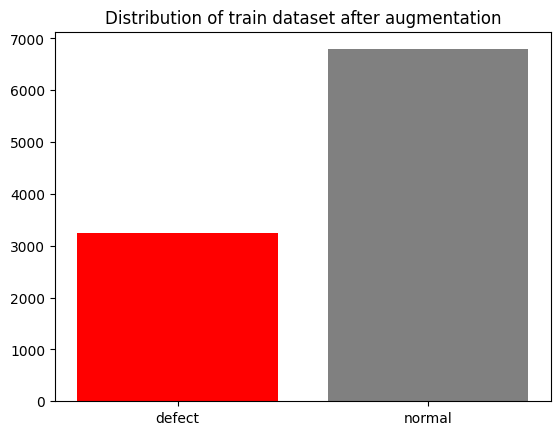

In [12]:
# 클래스 분포 체크
plt.bar(['defect', 'normal'], [augmented_defect_count, len(train_normal_images)], color=['red', 'gray'])
plt.title('Distribution of train dataset after augmentation')
plt.show()

# **Data Split** for Train, Valid: 데이터 분할

In [14]:
total_dataset = augmented_images + train_normal_images
label = [1] * len(augmented_images) + [0] * len(train_normal_images)

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(total_dataset,
                                                  label,
                                                  test_size=0.3,
                                                  shuffle=True,
                                                  random_state=42,
                                                  stratify=label)

print(f'train dataset: {len(X_train)}, val dataset: {len(X_val)}')
print(f'train label: {len(y_train)}, val label: {len(y_val)}')

train dataset: 7021, val dataset: 3009
train label: 7021, val label: 3009


In [15]:
X_train[:2]

[<PIL.Image.Image image mode=L size=512x512>,
 '/content/drive/MyDrive/aiConnect_2nd/data/train/normal_images/normal_3017.png']

# Pytorch CustomDataset 클래스 정의

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self): #데이터셋의 총개수를 뱉어줌
        return len(self.image_paths)

    def __getitem__(self, idx):
      image_data = self.image_paths[idx]
      if isinstance(image_data, str):
        image = cv2.imread(image_data, cv2.IMREAD_GRAYSCALE)
    # 이미지 객체인 경우 (예: PIL Image)
      elif isinstance(image_data, Image.Image):
        image = np.array(image_data)

      image = image / 255.0

      if self.transform:
        image = self.transform(image)

      label = self.labels[idx]

      return image, label

In [ ]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset,
                          batch_size=cfg.batch_size,
                          shuffle=True,
                          num_workers=2,
                          pin_memory=True)
test_loader = DataLoader(test_dataset,
                         batch_size=cfg.batch_size,
                         shuffle=False,
                         num_workers=2,
                         pin_memory=True)

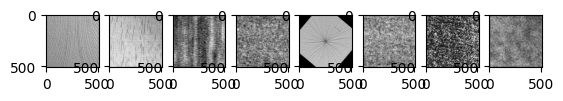

In [ ]:
# 데이터 샘플 체크
for batch in train_loader:
    imgs, labels = batch
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False) # 총 사진의 개수만큼 plot

    for i, img in enumerate(imgs):
        axs[0, i].imshow(img.squeeze(), cmap='gray')
    break

 # CNN Model 정의 (using-pretrained model)
 - resnet18d
 - tf_efficientnet_b5

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder =  timm.create_model('tf_efficientnet_b5', pretrained=True, in_chans=1)
        #self.encoder =  timm.create_model('resnet101', pretrained=True, in_chans=1)

        self.head = nn.Linear(1000, 1)

    def forward(self, image, mode='train'):
        x = self.encoder(image)
        output = self.head(x)
        output = torch.sigmoid(output)
        return output

In [ ]:
model_list = timm.list_models('')

# 모델, Loss, Optimizer 선언

In [ ]:
model = Net()

model = model.to(cfg.device)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

# 학습 모델 저장 경로 설정

In [ ]:
model_dir = './models'
os.makedirs(model_dir, exist_ok=True)

# 학습 및 검증

In [ ]:
# # Train and Valid Loop

# metric_best = 0.
# model_file = os.path.join(model_dir, f'best.pt')

# for epoch in range(cfg.epochs):
#     # Train Loop
#     train_loss = 0
#     train_outputs = []
#     train_labels = []
#     for batch in tqdm(train_loader, desc=f'train-{epoch}'):
#         imgs, labels = batch

#         imgs = imgs.to(cfg.device).float()
#         labels = labels.to(cfg.device)

#         optimizer.zero_grad()

#         output = model(imgs.unsqueeze(1))
#         loss = criterion(output, labels.unsqueeze(1).float())

#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#         train_outputs.append(output.cpu().detach())
#         train_labels.append(labels.cpu().detach())

#     train_loss /= len(train_loader)

#     # Validation Loop
#     val_loss = 0
#     val_outputs = []
#     val_labels = []
#     with torch.no_grad():
#         for batch in tqdm(test_loader, desc=f'val-{epoch}'): #배치간격으로 반복
#             imgs, labels = batch

#             imgs = imgs.to(cfg.device).float()
#             labels = labels.to(cfg.device)

#             output = model(imgs.unsqueeze(1))
#             loss = criterion(output, labels.unsqueeze(1).float())

#             val_loss += loss.item()
#             val_outputs.append(output.cpu().detach()) # detach 이것을 안시행하면 연산이 남아서 오류가날수도잇음
#             val_labels.append(labels.cpu().detach())

#     val_loss /= len(test_loader)
#     train_outputs = (torch.cat(train_outputs) > 0.5).float().squeeze(-1)
#     val_outputs = (torch.cat(val_outputs) > 0.5).float().squeeze(-1)
#     train_labels = torch.cat(train_labels)
#     val_labels = torch.cat(val_labels)

#     train_acc = accuracy_score(train_labels, train_outputs)
#     val_acc = accuracy_score(val_labels, val_outputs)

#     train_f1 = f1_score(train_labels, train_outputs, average='macro')
#     val_f1 = f1_score(val_labels, val_outputs, average='macro')

#     if val_f1 > metric_best:
#         print(f'metric_best ({metric_best:.6f} --> {val_f1:.6f}). Saving model ...')
#         torch.save(model.state_dict(), model_file)
#         metric_best = val_f1

#     print(f'Epoch: {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train Acc: {train_acc}, Val Acc: {val_acc}, Train F1: {train_f1}, Val F1: {val_f1}')


# Trainning, Validation and Visualization

In [ ]:
import matplotlib.pyplot as plt

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, cfg):
    train_losses = []
    val_losses = []
    train_f1s = []
    val_f1s = []
    metric_best = 0.
    model_file = os.path.join(model_dir, f'best.pt')

    for epoch in range(cfg.epochs):
        # Train Loop
        train_loss = 0
        train_outputs = []
        train_labels = []
        for batch in tqdm(train_loader, desc=f'train-{epoch}'):
            imgs, labels = batch
            imgs = imgs.to(cfg.device).float()
            labels = labels.to(cfg.device)

            optimizer.zero_grad()
            output = model(imgs.unsqueeze(1))
            loss = criterion(output, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_outputs.append(output.cpu().detach())
            train_labels.append(labels.cpu().detach())

        train_loss /= len(train_loader)

        # Validation Loop
        val_loss = 0
        val_outputs = []
        val_labels = []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'val-{epoch}'):
                imgs, labels = batch
                imgs = imgs.to(cfg.device).float()
                labels = labels.to(cfg.device)

                output = model(imgs.unsqueeze(1))
                loss = criterion(output, labels.unsqueeze(1).float())
                val_loss += loss.item()
                val_outputs.append(output.cpu().detach())
                val_labels.append(labels.cpu().detach())

        val_loss /= len(val_loader)
        train_outputs = (torch.cat(train_outputs) > 0.5).float().squeeze(-1)
        val_outputs = (torch.cat(val_outputs) > 0.5).float().squeeze(-1)
        train_labels = torch.cat(train_labels)
        val_labels = torch.cat(val_labels)

        train_acc = accuracy_score(train_labels, train_outputs)
        val_acc = accuracy_score(val_labels, val_outputs)

        train_f1 = f1_score(train_labels, train_outputs, average='macro')
        val_f1 = f1_score(val_labels, val_outputs, average='macro')

        if val_f1 > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {val_f1:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = val_f1

        print(f'Epoch: {epoch}')
        print(f'Train Loss: {train_loss}')
        print(f'Val Loss: {val_loss}')
        print(f'Train Acc: {train_acc}')
        print(f'Val Acc: {val_acc}')
        print(f'Train F1: {train_f1}')
        print(f'Val F1: {val_f1}')
        print('- - - - - - - - - - -')

        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

    return train_losses, val_losses, train_f1s, val_f1s

def plot_training_logs(train_losses, val_losses, train_f1s, val_f1s):
    epochs_range = range(len(train_losses))
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_f1s, label='Train F1')
    plt.plot(epochs_range, val_f1s, label='Val F1')
    plt.legend(loc='upper left')
    plt.title('Training and Validation F1 Score')

    plt.tight_layout()
    plt.show()




val-0: 100%|██████████| 377/377 [06:29<00:00,  1.03s/it]


metric_best (0.000000 --> 0.992360). Saving model ...
Epoch: 0
Train Loss: 0.06585066250967955
Val Loss: 0.029421902560586955
Train Acc: 0.9804871100982766
Val Acc: 0.9933532735127949
Train F1: 0.9775540319852074
Val F1: 0.9923598958772383
- - - - - - - - - - -


val-1: 100%|██████████| 377/377 [00:26<00:00, 14.46it/s]


metric_best (0.992360 --> 0.998859). Saving model ...
Epoch: 1
Train Loss: 0.007962988683877415
Val Loss: 0.0030391411216806347
Train Acc: 0.9981484119071358
Val Acc: 0.9990029910269193
Train F1: 0.9978829966754607
Val F1: 0.9988592848864914
- - - - - - - - - - -


val-2: 100%|██████████| 377/377 [00:26<00:00, 14.48it/s]


Epoch: 2
Train Loss: 0.010229680837196683
Val Loss: 0.005909223672743196
Train Acc: 0.9974362626406494
Val Acc: 0.9980059820538385
Train F1: 0.9970677495607819
Val F1: 0.9977179535147106
- - - - - - - - - - -


val-3: 100%|██████████| 377/377 [00:26<00:00, 14.50it/s]


metric_best (0.998859 --> 1.000000). Saving model ...
Epoch: 3
Train Loss: 0.0030925798635829975
Val Loss: 6.398881491056927e-05
Train Acc: 0.9992878507335138
Val Acc: 1.0
Train F1: 0.9991857679521002
Val F1: 1.0
- - - - - - - - - - -


val-4: 100%|██████████| 377/377 [00:26<00:00, 14.40it/s]


Epoch: 4
Train Loss: 0.007582686410159828
Val Loss: 0.000685880940564786
Train Acc: 0.998290841760433
Val Acc: 0.9996676636756398
Train F1: 0.99804561765738
Val F1: 0.9996201709546282
- - - - - - - - - - -


val-5: 100%|██████████| 377/377 [00:26<00:00, 14.35it/s]


Epoch: 5
Train Loss: 0.008597732588657944
Val Loss: 0.011979919516441933
Train Acc: 0.9974362626406494
Val Acc: 0.9956796277833168
Train F1: 0.9970684264860701
Val F1: 0.9950461639969581
- - - - - - - - - - -


val-6: 100%|██████████| 377/377 [00:26<00:00, 14.35it/s]


Epoch: 6
Train Loss: 0.003231297338420715
Val Loss: 0.003227310128069793
Train Acc: 0.999430280586811
Val Acc: 0.9993353273512795
Train F1: 0.9993485392191266
Val F1: 0.9992401376994733
- - - - - - - - - - -


val-7: 100%|██████████| 377/377 [00:26<00:00, 14.37it/s]


Epoch: 7
Train Loss: 0.0013403333313956518
Val Loss: 0.0006976951921177021
Train Acc: 0.9998575701467027
Val Acc: 0.9996676636756398
Train F1: 0.99983715359042
Val F1: 0.9996199665939396
- - - - - - - - - - -


val-8: 100%|██████████| 377/377 [00:26<00:00, 14.37it/s]


Epoch: 8
Train Loss: 3.13362775178251e-05
Val Loss: 0.0003098654430651361
Train Acc: 1.0
Val Acc: 0.9996676636756398
Train F1: 1.0
Val F1: 0.9996199665939396
- - - - - - - - - - -


val-9: 100%|██████████| 377/377 [00:26<00:00, 14.35it/s]


Epoch: 9
Train Loss: 0.01091686147519067
Val Loss: 0.00044408685966267926
Train Acc: 0.997721122347244
Val Acc: 1.0
Train F1: 0.9973947578267657
Val F1: 1.0
- - - - - - - - - - -


val-10: 100%|██████████| 377/377 [00:26<00:00, 14.38it/s]


Epoch: 10
Train Loss: 9.992701545523394e-05
Val Loss: 4.766755378403379e-05
Train Acc: 1.0
Val Acc: 1.0
Train F1: 1.0
Val F1: 1.0
- - - - - - - - - - -


val-11: 100%|██████████| 377/377 [00:26<00:00, 14.37it/s]


Epoch: 11
Train Loss: 0.003998839100716106
Val Loss: 0.021205114578289063
Train Acc: 0.9992878507335138
Val Acc: 0.9966766367563975
Train F1: 0.9991855800362548
Val F1: 0.9961903946796691
- - - - - - - - - - -


val-12: 100%|██████████| 377/377 [00:26<00:00, 14.37it/s]


Epoch: 12
Train Loss: 0.0036055038357649923
Val Loss: 7.502465816036545e-05
Train Acc: 0.9991454208802165
Val Acc: 1.0
Train F1: 0.9990228088286901
Val F1: 1.0
- - - - - - - - - - -


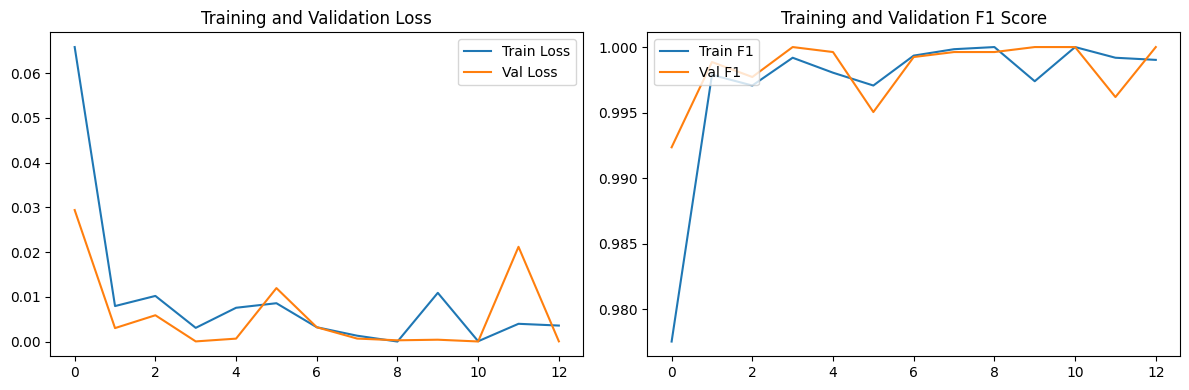

In [ ]:
# 함수 실행
train_losses, val_losses, train_f1s, val_f1s = train_and_validate(model, train_loader, test_loader, criterion, optimizer, cfg)
plot_training_logs(train_losses, val_losses, train_f1s, val_f1s)

# Pytorch CustomTestDataset 클래스 정의

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        image_path = self.image_paths[idx]
        image_name = os.path.basename(image_path)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = image / 255.0

        if self.transform:
            image = self.transform(image)

        return image, image_name

In [ ]:
test_images = glob(test_dir + '/images/*.png')

print(f'the number of test images : {len(test_images)}')

the number of test images : 9100


In [ ]:
test_dataset = CustomTestDataset(test_images)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)

# 학습된 모델 로드

In [ ]:
model_dir = './models'
model_file = os.path.join(model_dir, f'best.pt')

model = Net()
model.load_state_dict(torch.load(model_file))
model = model.to(cfg.device)

# 추론 수행

In [ ]:
image_names = []
test_outputs = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        imgs, image_name = batch
        imgs = imgs.to(cfg.device).float()

        output = model(imgs.unsqueeze(1))
        test_outputs.append(output.cpu().detach())
        image_names.extend(image_name)

test_outputs = (torch.cat(test_outputs) > 0.5).int().squeeze(-1)

100%|██████████| 1138/1138 [05:18<00:00,  3.58it/s]


# 추론 결과 저장

In [ ]:
submission = pd.DataFrame({'ImageId': image_names, 'answer': test_outputs.tolist()})
submission = submission.sort_values(by=['ImageId']).reset_index(drop=True)

In [ ]:
submission.to_csv('/content/drive/MyDrive/yeardream_2nd/submission_fri1_tfefnetb8_rl-4.csv', index=False)

In [ ]:
submission

,ImageId,answer
0,test_0000.png,0
1,test_0001.png,0
2,test_0002.png,0
3,test_0003.png,0
4,test_0004.png,0
...,...,...
9095,test_9095.png,0
9096,test_9096.png,0
9097,test_9097.png,0
9098,test_9098.png,1


In [ ]:
submission['answer'].value_counts()

0    7306
1    1794
Name: answer, dtype: int64

In [ ]:
print("완료")

완료
